In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC, SVR
import pprint as pp

%matplotlib inline

## Helper Functions Library

### Preprocessing Pipeline

In [31]:
def make_preprocessor(numeric_cols, categorical_cols, scale_numeric=True):
    """
    Builds a preprocessing pipeline with optional scaling.
    """

    transformers = []

    if scale_numeric:
        transformers.append(
            ('num', StandardScaler(), numeric_cols)
        )
    else:
        transformers.append(
            ('num', 'passthrough', numeric_cols)
        )

    transformers.append(
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    )

    preprocessor = ColumnTransformer(transformers)
    return preprocessor

### Basic Model Training Helper

In [3]:
def build_pipeline(preprocessor, clf):
    """
    Creates a modeling pipeline combining preprocessing and model.
    """

    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', clf)
    ])

    return pipe

In [42]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a trained model and returns useful metrics
    """

    y_pred = model.predict(X_test)

    # If classifier supports predict_proba
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # use decision function as a fallback
        y_proba = model.decision_function(X_test)

    metrics = {
        "test_auc": roc_auc_score(y_test, y_proba),
        "confusion_matrix": confusion_matrix(y_test, y_pred, labels=model.classes_),
        "report": classification_report(y_test, y_pred, output_dict=False)
    }

    return metrics
    

### GridSearchCV Wrapper

In [43]:
def run_grid_search(pipe, param_grid, X_train, y_train, scoring='roc_auc', cv=5):
    """
    Runs GridSearchCV on a given pipeline
    """

    grid = GridSearchCV(pipe, param_grid, 
                        scoring=scoring,
                        cv=cv,
                        n_jobs=-1,
                        verbose=1
                       )

    grid.fit(X_train, y_train)

    return grid

### Multi-models Loop

In [54]:
def run_multiple_models(models, grids, preprocessor,
                       X_train, y_train, X_test, y_test, scoring='roc_auc'):
    """
    Runs grid search for multiple models and stores the results.
    """

    results = {}

    for name, clf in models.items():
        print(f"\n===== Training {name} =====")

        pipe = build_pipeline(preprocessor, clf)
        param_grid = grids[name]

        grid = run_grid_search(pipe, param_grid, X_train, y_train, scoring=scoring)

        # Best estimator
        best_model = grid.best_estimator_

        # Evaluate
        metrics = evaluate_model(best_model, X_test, y_test)

        results[name] = {
            "best_prams": grid.best_params_,
            "cv_best_score": grid.best_score_,
            "test_metrics": metrics
        }
        print(f"Best Params: {grid.best_params_}")
        print(f"AUC (CV): {grid.best_score_:.4f}")
        print(f"AUC (Test): {metrics['test_auc']:.4f}")
        print(f"Report:\n {metrics['report']}")
        cm = metrics['confusion_matrix']
        plt.figure(figsize=(4,4))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
        disp.plot(cmap="Blues", colorbar=False)
        plt.show()
        

    return results

### Models

In [27]:
all_models = {
    # ---- Linear Models ----
    "lin_reg": LinearRegression(),
    "log_reg": LogisticRegression(max_iter=500),

    # ---- Decision Trees ----
    "dt_reg": DecisionTreeRegressor(),
    "dt_clf": DecisionTreeClassifier(),

    # ---- Random Forests ----
    "rf_reg": RandomForestRegressor(),
    "rf_clf": RandomForestClassifier(),

    # ---- Boosting -----
    "gb_clf": GradientBoostingClassifier(),
    "ada_clf": AdaBoostClassifier(),

    # ---- Bagging -----
    "bag_clf": BaggingClassifier(estimator=DecisionTreeClassifier()),

    # ---- SVM -----
    "lin_svc": LinearSVC(),
    "svc_poly": SVC(kernel='poly', probability=True),
    "svc_rbf": SVC(kernel='rbf', probability=True),
    "svr": SVR(kernel='rbf')
}


### Parameter Grids

In [48]:
# Basic parameter grids
all_param_grids = {

    # ---- Linear Regression (no params) ----
    "lin_reg": {},

    # ---- Logistic Regression ----
    "log_reg": {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__class_weight": [None, "balanced"]
    },

    # ---- Decision Tree Regressor ----
    "dt_reg": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    },

    # ---- Decision Tree Classifier ----
    "dt_clf": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__min_samples_split": [2, 5, 10]
        # TODO:  "clf__min_impurity_decrease": 
    },

    # ---- Random Forest Regressor ----
    "rf_reg": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__min_samples_split": [2, 5]
    },

    # ---- Random Forest Classifier ----
    "rf_clf": {
        "clf__n_estimators": [100, 200, 300],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__class_weight": [None, "balanced"]
    },

    # ---- Gradient Boosting Classifier ----
    "gb_clf": {
        "clf__n_estimators": [100, 200],
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__max_depth": [3, 5],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__min_samples_split": [2, 5]
    },

    # ---- AdaBoost Classifier ----
    "ada_clf": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.5, 1.0, 1.5]
    },

    # ---- Bagging Classifier ----
    "bag_clf": {
        "clf__n_estimators": [10, 50, 100],
        "clf__max_samples": [0.5, 0.7, 1.0]
    },

    # ---- LinearSVC ----
    "lin_svc": {
        "clf__C": [0.1, 1, 10],
        "clf__loss": ["hinge", "squared_hinge"]
    },

    # ---- SVC (Poly Kernel) ----
    "svc_poly": {
        "clf__C": [0.1, 1, 10],
        "clf__degree": [2,3,4],
        "clf__gamma": ["scale", .01, .1],
        "clf__coef0": [0, 1],
        "clf__class_weight": [None, "balanced"]
    },

    # ---- SVC (RBF Kernel) ----
    "svc_rbf": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", 0.01, 0.1],
        "clf__class_weight": [None, "balanced"]
    },

    # ---- SVR ----
    "svr": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", 0.01, 0.1],
        "clf__epsilon": [0.1, 0.2, 0.5]
    }
}

### Load Dataset and Perform EDA

In [9]:
filename = "data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(filename)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [11]:
df.drop(columns=['id'], inplace=True)
df['hypertension'] = df['hypertension'].map({1: 'Yes', 0: 'No'})
df['heart_disease'] = df['heart_disease'].map({1: 'Yes', 0: 'No'})
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,No,No,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [12]:
df.describe()

,age,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,106.147677,28.893237,0.048728
std,22.612647,45.283560,7.854067,0.215320
min,0.080000,55.120000,10.300000,0.000000
25%,25.000000,77.245000,23.500000,0.000000
50%,45.000000,91.885000,28.100000,0.000000
75%,61.000000,114.090000,33.100000,0.000000
max,82.000000,271.740000,97.600000,1.000000


In [13]:
# Explore categorical's values
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}'s unique values: {df[col].unique()}")

gender's unique values: ['Male' 'Female' 'Other']
hypertension's unique values: ['No' 'Yes']
heart_disease's unique values: ['Yes' 'No']
ever_married's unique values: ['Yes' 'No']
work_type's unique values: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type's unique values: ['Urban' 'Rural']
smoking_status's unique values: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [14]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [15]:
df = df.dropna().copy()
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [16]:
# Prepare features lists
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
numerical_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'stroke']
target_col = ['stroke']
print(f"categorical cols: {categorical_cols}")
print(f"numerical cols: {numerical_cols}")

categorical cols: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical cols: ['age', 'avg_glucose_level', 'bmi']


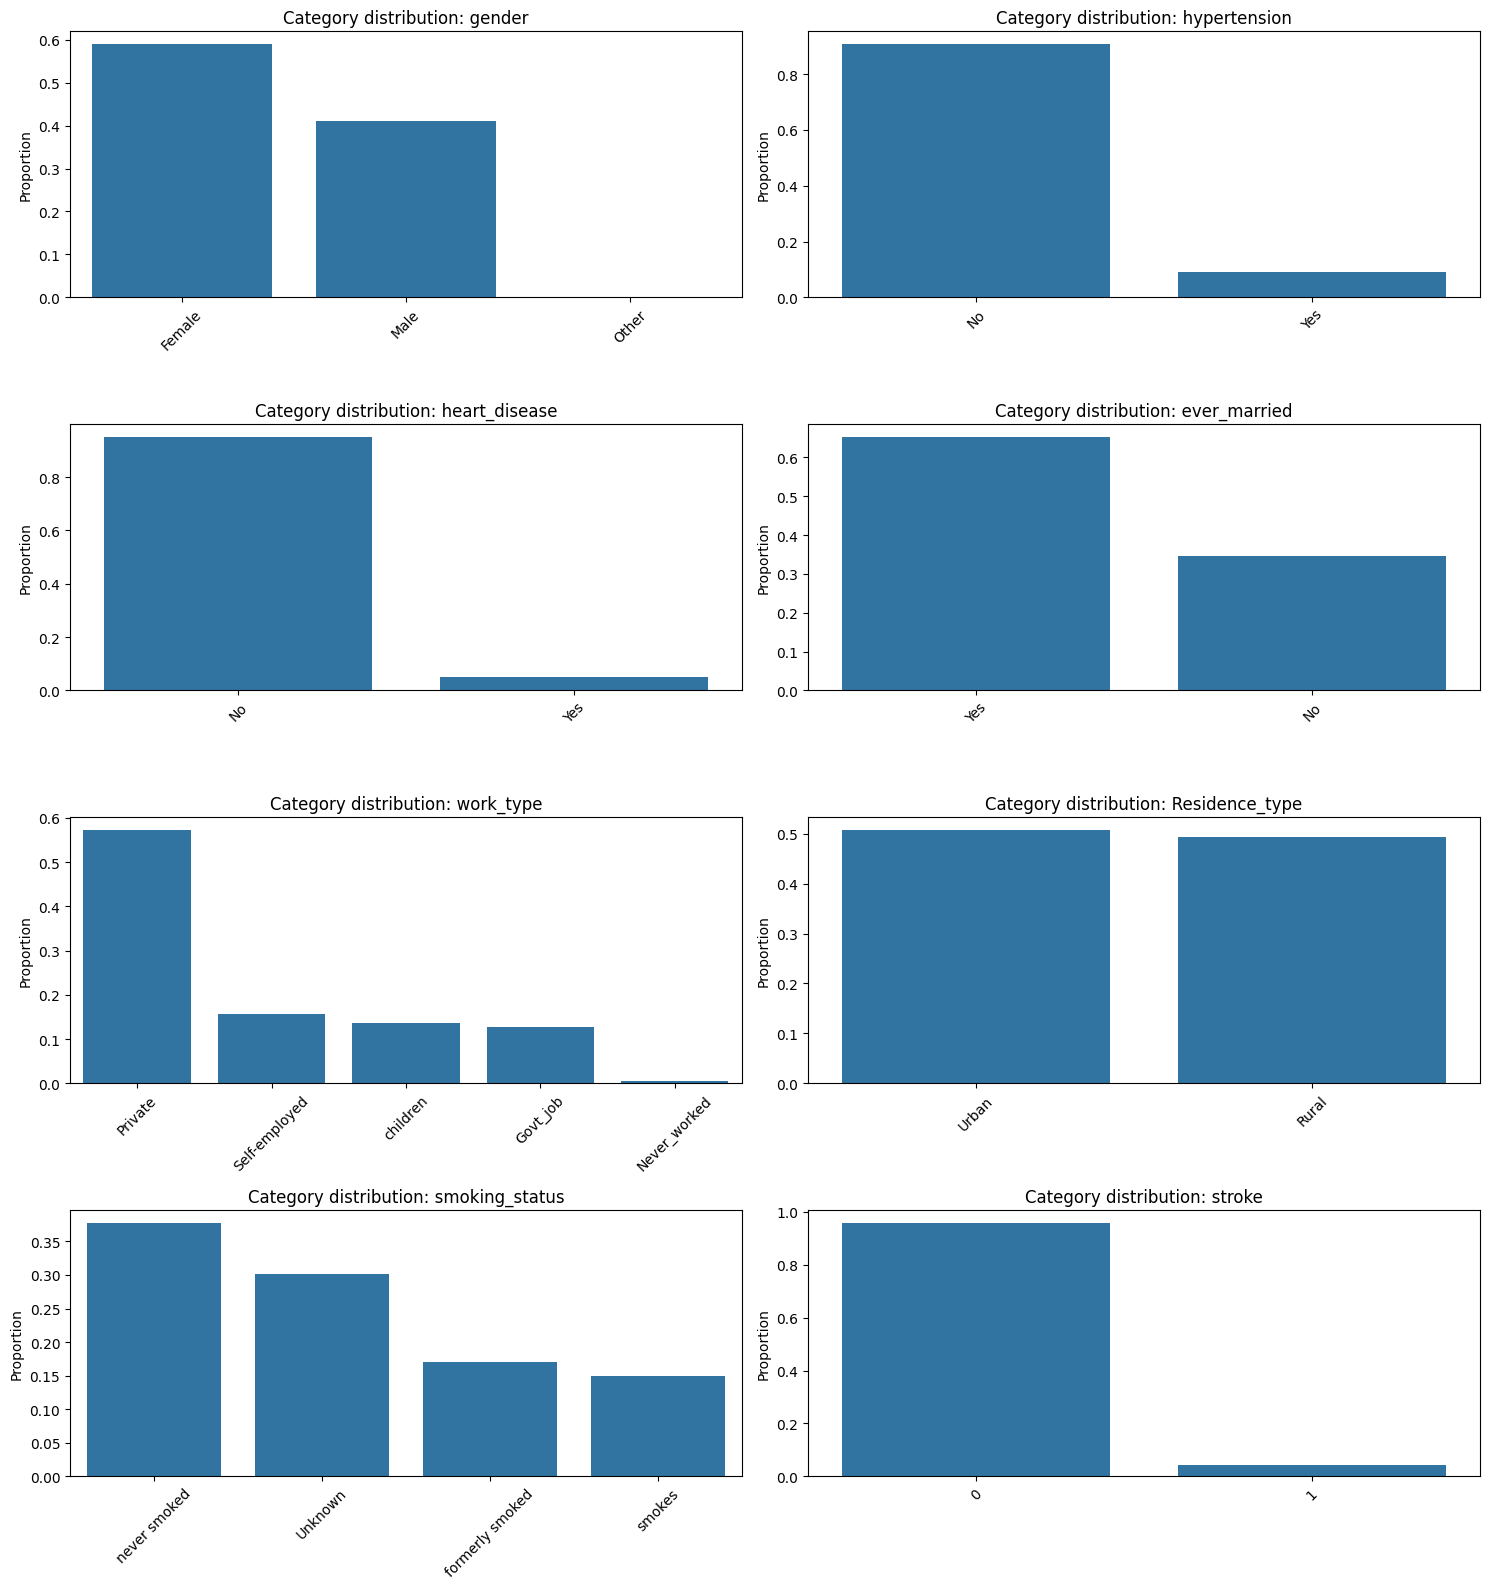

In [17]:
#Inspect categorical features' distribution
n_cols = 2
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()
    
for i, col in enumerate(categorical_cols+target_col):
    ax = axes[i]

    #Compute proportions
    dist = df[col].value_counts(normalize=True).reset_index()
    dist.columns = [col, "proportion"]
    
    sns.barplot(data=dist, x=col, y="proportion", ax=ax)
    
    ax.set_title(f"Category distribution: {col}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45)
    
# Turn off empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

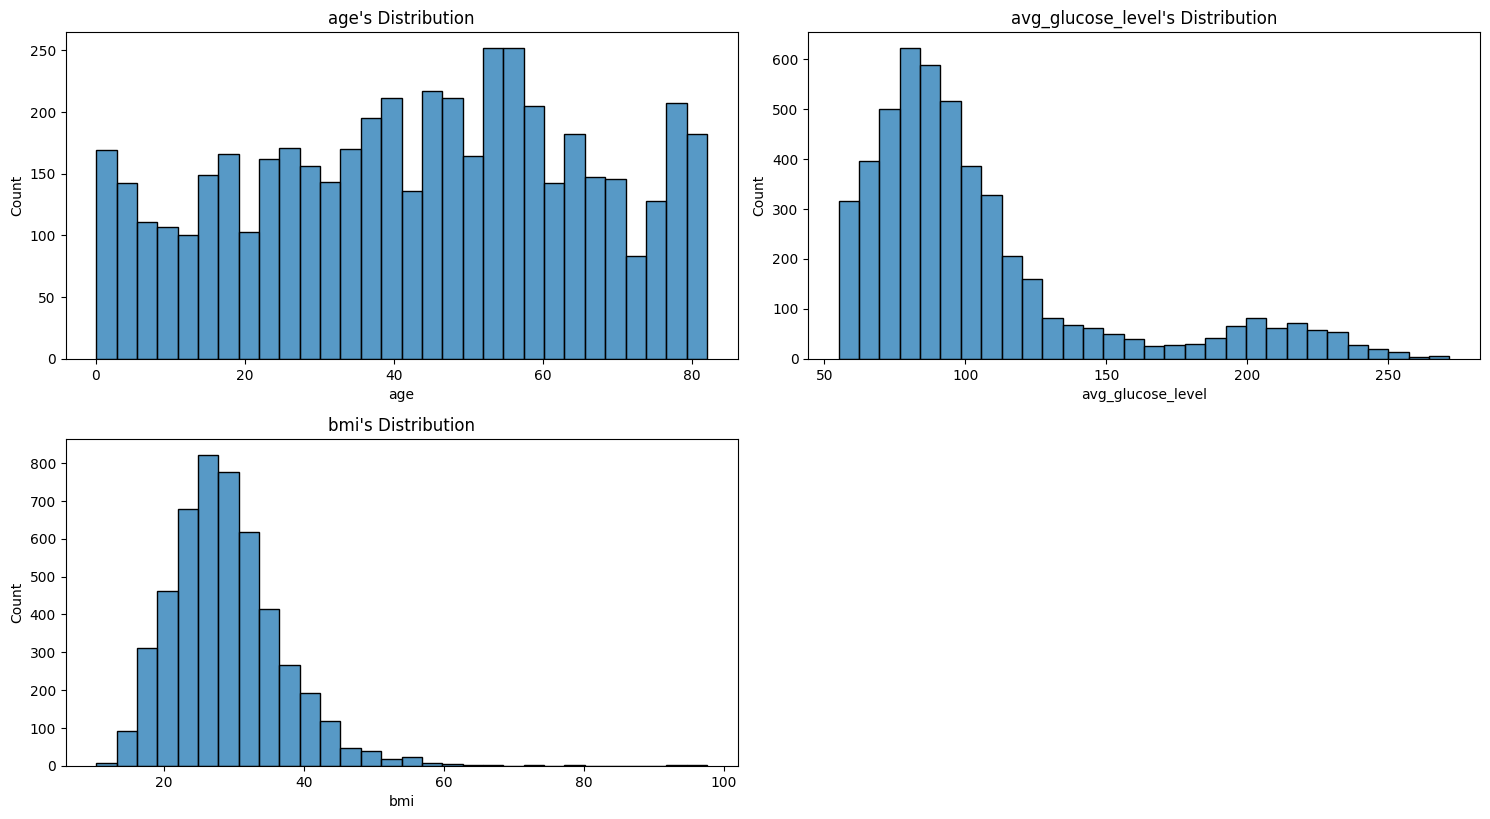

In [18]:
#Inspect numerical features' distribution

n_cols = 2
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes =axes.flatten()

for i, col, in enumerate(numerical_cols):
    ax = axes[i]

    sns.histplot(data=df, x=df[col], bins=30, ax=ax)

    ax.set_title(f"{col}'s Distribution")


# Turn off empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Observations

#### Age
- normally distributed


#### Averege glucose level
- seems well distributed, with a moderate skew to the right


#### BMI
- normally distributed









### Inspect feature-to-target relationship

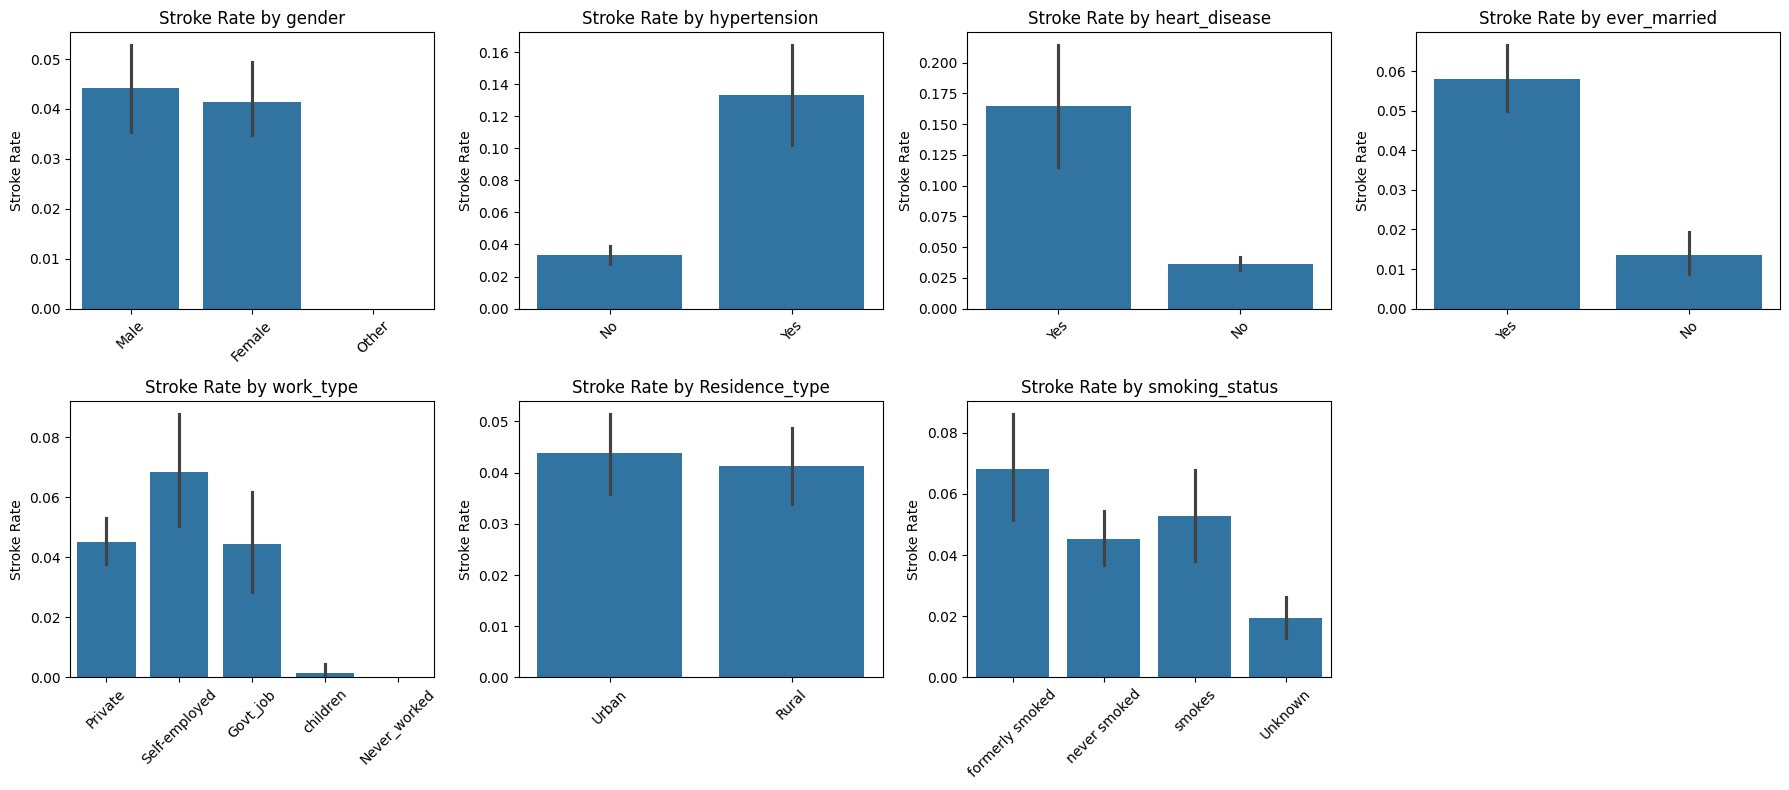

In [19]:
# Determine grid size (4 plots per row)
n_cols = 4
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    sns.barplot(data=df, x=col, y="stroke", ax=ax, estimator=np.mean)
    ax.set_title(f"Stroke Rate by {col}")
    ax.set_ylabel("Stroke Rate")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45)

# Turn off empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Observations

### Gender
- `male` and `female` seems normally distributed
- `other` category is extremely low (<1%)

#### Action:
- Merge `other` into a generic `Unknown` group to prevent useless sparse columns when using one-hot encoding


### Work Type
- `never_worked` extremely low (<1%)
- `children` very low (~5%) but still relevent

#### Action:
- merge `never_worked` with `children`, also to prevent useless sparse columns with one-hot encoding


### Hypertension, heart-disease and smoking status
- distribution makes sense as it shows the potential risks associated with stroke. Keep as is.


### Ever married
- A bit of imbalance here, however, this could be a predictor of stroke. Keep as is.


### Residence type
- well distributed. Keep as is.

In [20]:
# Gender category
infoFrame = df['gender'].value_counts().to_frame(name="count")
infoFrame["proportion"] = df['gender'].value_counts(normalize=True)
infoFrame

,count,proportion
gender,,
Female,2897,0.590141
Male,2011,0.409656
Other,1,0.000204


#### Update On action
- After observing that `other` only has one observation out of almost 5000, the statistical insignificance of keeping it in `other` will not have any impact on modeling. Furthermore, it is actually the only observation that would have ended up in `Unknown`, so I decided to leave it as is.

In [21]:
# Work type category
infoFrame = df['work_type'].value_counts().to_frame(name="count")
infoFrame["proportion"] = df['work_type'].value_counts(normalize=True)
infoFrame

,count,proportion
work_type,,
Private,2811,0.572622
Self-employed,775,0.157873
children,671,0.136688
Govt_job,630,0.128336
Never_worked,22,0.004482


In [22]:
# Merge `never_worked` with `children`
df['work_type'] = df['work_type'].replace({'Never_worked': 'children'})
infoFrame = df['work_type'].value_counts().to_frame(name="count")
infoFrame["proportion"] = df['work_type'].value_counts(normalize=True)
infoFrame

,count,proportion
work_type,,
Private,2811,0.572622
Self-employed,775,0.157873
children,693,0.141169
Govt_job,630,0.128336


### Numeric-vs-stroke boxplots

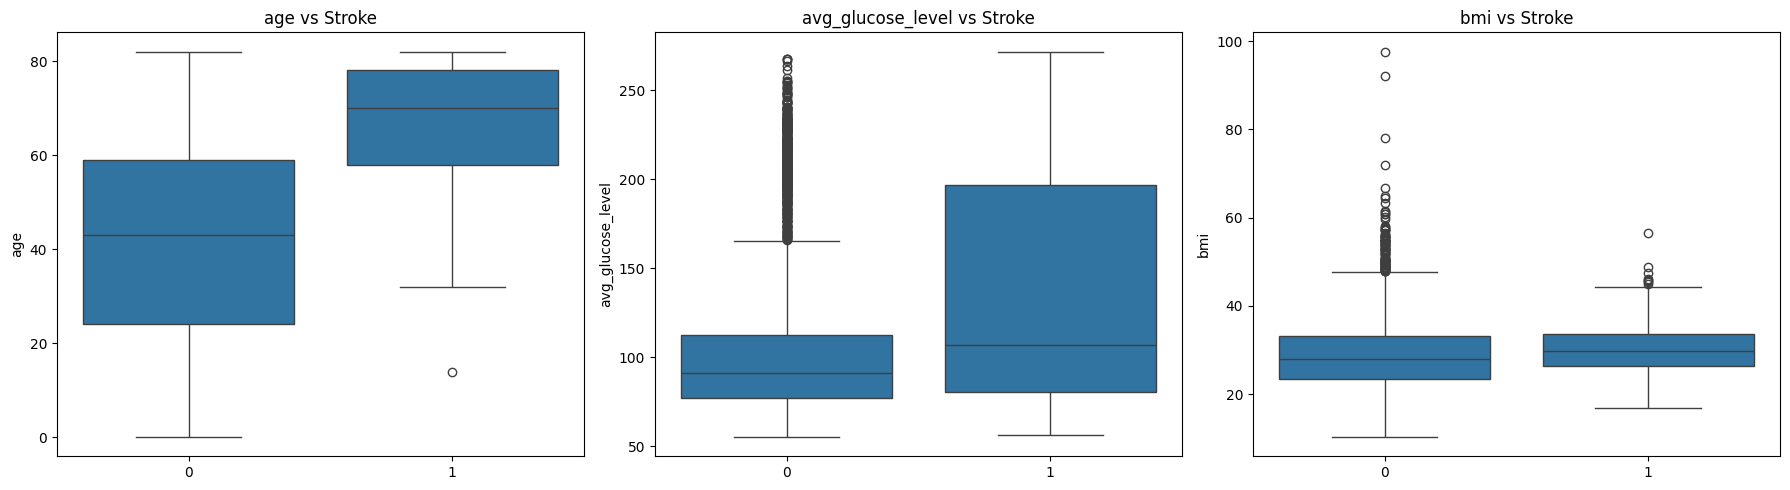

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(['age', 'avg_glucose_level', 'bmi']):
    sns.boxplot(data=df, x="stroke", y=col, ax=axes[i])
    axes[i].set_title(f"{col} vs Stroke")
    axes[i].set_xlabel("")
plt.tight_layout()
plt.show()

### Correlation with the stroke target (numeric only)

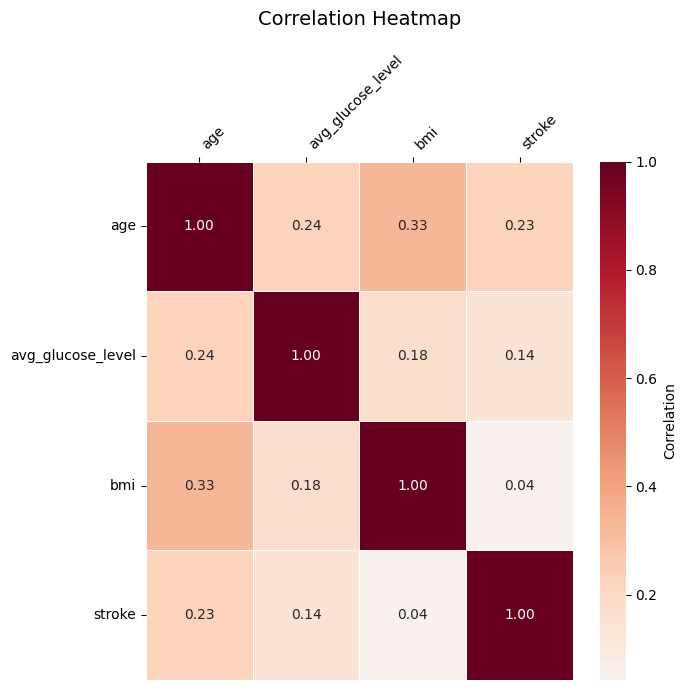

In [24]:
corr_data = df[['age', 'avg_glucose_level', 'bmi', 'stroke']].corr()

plt.figure(figsize=(7,7))
sns.heatmap(data=corr_data, 
            annot=True,
            fmt=".2f",
            cmap="RdBu_r",
            center=0,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation'})

plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

plt.xticks(rotation=45, ha='left', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Correlation Heatmap", pad=20, fontsize=14)

plt.tight_layout()

#plt.savefig("imgs/heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

### Post EDA observations

#### A) Strong class imbalance
 - Stroke cases ~5% vs non-stroke cases ~95%

#### Consequences

 - accuracy becomes meaningless
 - recall for the positive class is crucial
 - ROC-AUC is a better general metric than accuracy
 - Precision is important if you care about reducing false alerts
 - Treshold tuning may be needed after training

##### Plan
- use class_weight, recall, or AUC-focused models


#### B) Mix of Feature Types

- Numeric: `age`, `avg_glucose_level`, `BMI`
- Categorical: `gender`, `ever_married`, `work_type`, `Residene_type`, `smoking_status`, `hypertension`, `heart_disease`
    - will require ColumnTransformer with scaling + one-hot encoding

- SVMs and LogisticRegession require scaling
- Trees and ensembles do not use scaling


#### C) Some Numeric Features are skewed

- `avg_glucose_level` is moderately right-skewed
- `BMI` approximately gamma-shaped
-  `age` has natural peaks

- Scaling neede for SMV, LogisticRegression


#### D) Rare categories in Categorical Features

- `gender`: 'other' appears once
- `work_type`: 'never_worked' merged with 'children'

- Rare level should not harm tree-models
- But may destabilize linear models if one-hot produces sparse columns


#### D) Medical dataset

- clinical variables matter: `hypertension`, `heat_disease`, `age`
- high interpretability is desirable
- models must avoid bias against minority categories

- Prefer models with interpretable explanations (LogReg, Tree-based)

### Run models

In [57]:
# Prepare train and test datasets

X = df.drop(columns=["stroke"])
y = df["stroke"]

print("Original:")
print(df["stroke"].value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, 
                                                    random_state=42, 
                                                    stratify=y)


print("Train:")
print(y_train.value_counts(normalize=True))

print("Test:")
print(y_test.value_counts(normalize=True))

Original:
stroke
0    0.957425
1    0.042575
Name: proportion, dtype: float64
Train:
stroke
0    0.957474
1    0.042526
Name: proportion, dtype: float64
Test:
stroke
0    0.95723
1    0.04277
Name: proportion, dtype: float64



===== Training log_reg =====
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2'}
AUC (CV): 0.8537
AUC (Test): 0.8124
Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       940
           1       0.00      0.00      0.00        42

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.96      0.94       982



/Users/jobicari/miniconda3/envs/ds-env-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jobicari/miniconda3/envs/ds-env-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jobicari/miniconda3/envs/ds-env-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

<Figure size 400x400 with 0 Axes>

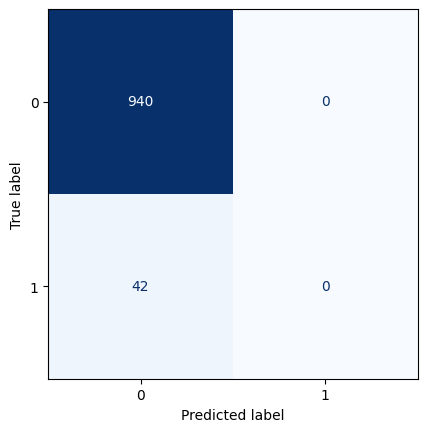


===== Training rf_clf =====
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Params: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
AUC (CV): 0.8395
AUC (Test): 0.7577
Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       940
           1       0.00      0.00      0.00        42

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.96      0.94       982



/Users/jobicari/miniconda3/envs/ds-env-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jobicari/miniconda3/envs/ds-env-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jobicari/miniconda3/envs/ds-env-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

<Figure size 400x400 with 0 Axes>

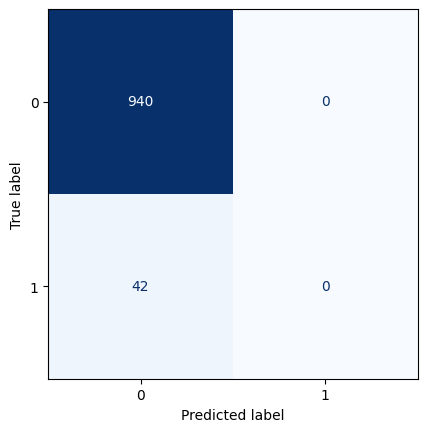


===== Training gb_clf =====
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
AUC (CV): 0.8532
AUC (Test): 0.8015
Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       940
           1       0.00      0.00      0.00        42

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.96      0.94       982



/Users/jobicari/miniconda3/envs/ds-env-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jobicari/miniconda3/envs/ds-env-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jobicari/miniconda3/envs/ds-env-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

<Figure size 400x400 with 0 Axes>

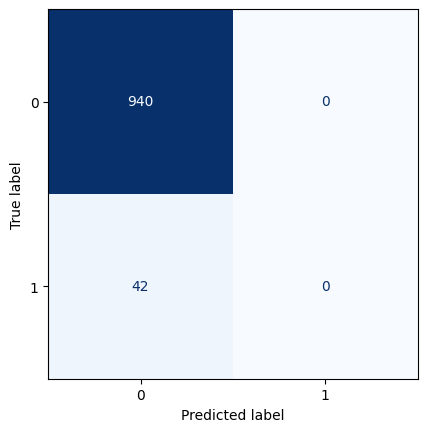


===== Training svc_rbf =====
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Params: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01}
AUC (CV): 0.8525
AUC (Test): 0.8107
Report:
               precision    recall  f1-score   support

           0       0.98      0.71      0.83       940
           1       0.10      0.74      0.18        42

    accuracy                           0.72       982
   macro avg       0.54      0.73      0.50       982
weighted avg       0.95      0.72      0.80       982



<Figure size 400x400 with 0 Axes>

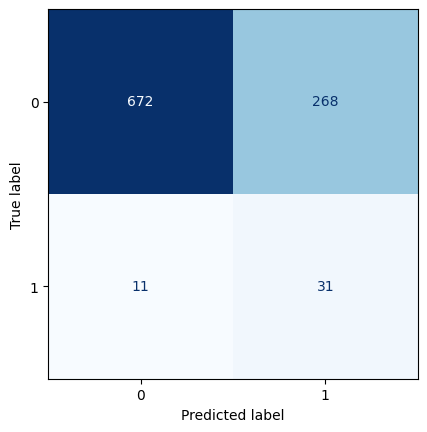

Final results
{'gb_clf': {'best_prams': {'clf__learning_rate': 0.01,
                           'clf__max_depth': 3,
                           'clf__min_samples_leaf': 2,
                           'clf__min_samples_split': 5,
                           'clf__n_estimators': 100},
            'cv_best_score': np.float64(0.85323877858687),
            'test_metrics': {'confusion_matrix': array([[940,   0],
       [ 42,   0]]),
                             'report': '              precision    recall  '
                                       'f1-score   support\n'
                                       '\n'
                                       '           0       0.96      1.00      '
                                       '0.98       940\n'
                                       '           1       0.00      0.00      '
                                       '0.00        42\n'
                                       '\n'
                                       '    accuracy             

In [59]:
preprocessor = make_preprocessor(numerical_cols, categorical_cols, scale_numeric=True)

selected_models = ["log_reg", "rf_clf", "gb_clf", "svc_rbf"]

# Apply selection to models and param_grids librairy
models = {name: all_models[name] for name in selected_models}
param_grids = {name: all_param_grids[name] for name in selected_models}

results = run_multiple_models(models, param_grids, preprocessor,
                            X_train, y_train, X_test, y_test, scoring='roc_auc')

print("Final results")
pp.pprint(results)
